In [1]:
import numpy as np
import pandas as pd
import transformers
import torch

from tqdm import tqdm, trange
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

2024-05-23 11:05:13.722073: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-23 11:05:13.768069: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-23 11:05:14.615664: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

print(f'There are {torch.cuda.device_count()} GPU(s) available.')
print('Device name:', torch.cuda.get_device_name(0))

There are 1 GPU(s) available.
Device name: NVIDIA RTX A5000


In [3]:
benign_data = pd.read_csv("/home/vikrant/Desktop/Thesis/Thesis_Projects/URL_detection/Benign.csv")

malicious_data = pd.read_csv("/home/vikrant/Desktop/Thesis/Thesis_Projects/URL_detection/Malicious.csv")

df1 = pd.DataFrame(benign_data)
df2 = pd.DataFrame(malicious_data)

x = df1.sample(25000)
y = df2.sample(25000)

data = pd.concat([x,y], axis=0)
data = shuffle(data)
data

,url,label
5835,pastehtml.com/view/c0mdft7up.html,1
33027,www.markwell.btinternet.co.uk/webmon/,0
14521,www.michaelp.org/transputer/,0
9102,bit.ly/QHN9ie,1
4198,www.hsqxx.com/js/?us.battle.net/login/en/?ref=...,1
...,...,...
10757,'www.gzqb.com.cn/Images/?us.battle.net/login/e...,1
23766,'paypal.com.us.cgi-bin.webscr-cmd.login-run.di...,1
32456,www.darsbydesign.com/wallpaper.htm,0
36105,www.thp.uni-duisburg.de/Ygl/ReadMe.html,0


In [4]:
sentences = data['url'].values
labels = data['label'].values

In [5]:
# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained('google/electra-large-generator')

/home/vikrant/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [6]:
# Tokenize the sentences
input_ids = []
attention_masks = []

max_length = 128  # Adjusted sequence length for better performance

for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,
                        add_special_tokens=True,
                        max_length=max_length,
                        pad_to_max_length=True,
                        return_attention_mask=True,
                        return_tensors='pt',
                   )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/vikrant/anaconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [7]:
# Split the data into 80% training and 20% test set
train_inputs, test_inputs, train_labels, test_labels = train_test_split(input_ids, labels,
                                                                        random_state=2018, test_size=0.2)
train_masks, test_masks, _, _ = train_test_split(attention_masks, attention_masks,
                                                 random_state=2018, test_size=0.2)

# Further split the training data into 75% training and 25% validation
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(train_inputs, train_labels,
                                                                                    random_state=2018, test_size=0.25)
train_masks, validation_masks, _, _ = train_test_split(train_masks, train_masks,
                                                       random_state=2018, test_size=0.25)

# Create the DataLoader for training, validation, and test sets
batch_size_train = 32
batch_size_val = 64

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size_train)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size_val)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size_val)


In [8]:
# Load the pre-trained model
model = AutoModelForSequenceClassification.from_pretrained(
    "google/electra-large-generator",
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
)

model.to(device)

/home/vikrant/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/home/vikrant/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/home/vikrant/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/205M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-large-generator and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (embeddings_project): Linear(in_features=1024, out_features=256, bias=True)
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-23): 24 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense

In [9]:
# Set up the optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

epochs = 10
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


/home/vikrant/anaconda3/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [10]:
# Early stopping criteria
patience = 2
early_stopping_counter = 0
best_validation_loss = float('inf')

In [11]:
# Training loop
loss_values, validation_loss_values = [], []

for epoch_i in range(0, epochs):
    print(f'Epoch {epoch_i + 1}/{epochs}')
    print('Training...')

    model.train()
    total_loss = 0

    # Shuffle the training data at the beginning of each epoch
    train_dataloader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=batch_size_train)

    for step, batch in enumerate(train_dataloader):
        b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)

        model.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    loss_values.append(avg_train_loss)
    print(f'Average training loss: {avg_train_loss}')

    print('Running Validation...')
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    for batch in validation_dataloader:
        b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        logits = outputs.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_loss = outputs.loss.item()  # Adjusted this line to correctly access loss
        eval_loss += tmp_eval_loss

        preds_flat = np.argmax(logits, axis=1).flatten()
        labels_flat = label_ids.flatten()
        eval_accuracy += np.sum(preds_flat == labels_flat) / len(labels_flat)

        nb_eval_steps += 1

    avg_val_accuracy = eval_accuracy / nb_eval_steps
    avg_val_loss = eval_loss / nb_eval_steps
    validation_loss_values.append(avg_val_loss)

    print(f'Validation Accuracy: {avg_val_accuracy}')
    print(f'Validation Loss: {avg_val_loss}')

    # Early stopping
    if avg_val_loss < best_validation_loss:
        best_validation_loss = avg_val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print('Early stopping triggered.')
        break

print(f'Training complete!')

Epoch 1/10
Training...
Average training loss: 0.29513706118345007
Running Validation...
Validation Accuracy: 0.9658638535031847
Validation Loss: 0.10949218982628955
Epoch 2/10
Training...
Average training loss: 0.11268663659854643
Running Validation...
Validation Accuracy: 0.9758160828025477
Validation Loss: 0.07999767497727636
Epoch 3/10
Training...
Average training loss: 0.07896476830772833
Running Validation...
Validation Accuracy: 0.9754179936305732
Validation Loss: 0.09825639004202168
Epoch 4/10
Training...
Average training loss: 0.055617200027379805
Running Validation...
Validation Accuracy: 0.9794984076433121
Validation Loss: 0.09044117493715113
Early stopping triggered.
Training complete!


              precision    recall  f1-score   support

           0     0.9731    0.9747    0.9739      4931
           1     0.9753    0.9738    0.9745      5069

    accuracy                         0.9742     10000
   macro avg     0.9742    0.9742    0.9742     10000
weighted avg     0.9742    0.9742    0.9742     10000



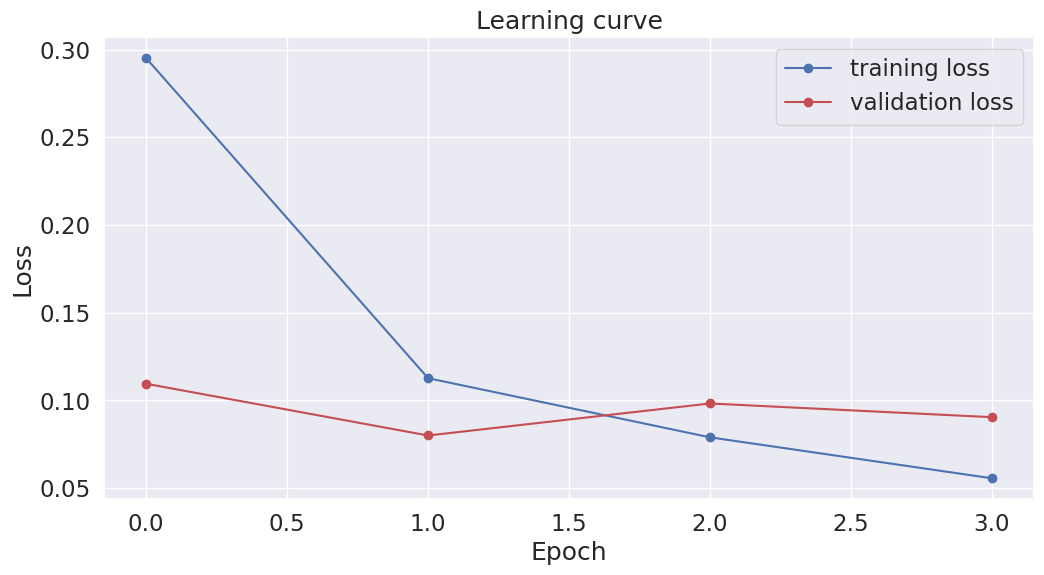

In [12]:
# Load the best model
model.load_state_dict(torch.load('best_model.pt'))

# Evaluate on the test set
model.eval()
predictions, true_labels = [], []

for batch in test_dataloader:
    b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = outputs.logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    predictions.extend(np.argmax(logits, axis=1).flatten())
    true_labels.extend(label_ids.flatten())

# Print classification report
print(classification_report(true_labels, predictions, digits=4))

# Plot the learning curve
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()